# AlexNet CIFAR-10 Classifier

This notebook implements the classic AlexNet convolutional network [1] and applies it to the CIFAR10 object classification dataset. The basic architecture is shown in the figure below:

![](./images/alextnet/alextnet-1.jpg)

It contains 5 convolutional layers and 3 fully connected layers. Relu is applied after very convolutional and fully connected layer. Dropout is applied before the first and the second fully connected year. The image size in the following architecutre chart should be 227 * 227 instead of 224 * 224, as it is pointed out by Andrei Karpathy in his famous CS231n Course. More insterestingly, the input size is 224 * 224 with 2 padding in the pytorch torch vision. The output width and height should be (224–11+4)/4 + 1=55.25! The explanation here is pytorch Conv2d apply floor operator to the above result, and therefore the last one padding is ignored.

Some of the highlights in AlexNet Architecture:

- It uses `ReLU` activation function instead Sigmoid or Tanh functions. It speed by more than 5 times faster with same accuracy
- It uses `Dropout` instead of regularisation to deal with overfitting. But the training time is doubled with dropout ratio of 0.5
- More data and bigger model with 7 hidden layers, 650K units and 60M parameters.

In [1]:
import pandas as pd
pd.read_csv("alextnet_params.csv",na_filter ="")

,Size / Operation,Filter,Depth,Stride,Padding,Number of Parameters,Forward Computation
0,3* 227 * 227,,,,,,
1,Conv1 + Relu,11 * 11,96,4,,(11*11*3 + 1) * 96=34944,(11*11*3 + 1) * 96 * 55 * 55=105705600
2,96 * 55 * 55,,,,,,
3,Max Pooling,3 * 3,,2,,,
4,96 * 27 * 27,,,,,,
5,Norm,,,,,,
6,Conv2 + Relu,5 * 5,256,1,2,(5 * 5 * 96 + 1) * 256=614656,(5 * 5 * 96 + 1) * 256 * 27 * 27=448084224
7,256 * 27 * 27,,,,,,
8,Max Pooling,3 * 3,,2,,,
9,256 * 13 * 13,,,,,,


References
    
- [1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "[Imagenet classification with deep convolutional neural networks.](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)" In Advances in Neural Information Processing Systems, pp. 1097-1105. 2012.

In [2]:
import sys
sys.path.append("/Users/ZRC")
sys.path

['',
 '/anaconda/envs/py36/lib/python36.zip',
 '/anaconda/envs/py36/lib/python3.6',
 '/anaconda/envs/py36/lib/python3.6/lib-dynload',
 '/anaconda/envs/py36/lib/python3.6/site-packages',
 '/anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions',
 '/data/home/zhangruochi/.ipython',
 '/Users/ZRC']

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler


from torchvision import datasets
from torchvision import transforms

from torchsummary import summary

In [36]:
from fastai.utils import mem

In [41]:
print(mem.gpu_mem_get())
torch.cuda.empty_cache()
print(mem.gpu_mem_get())

GPUMemory(total=11441, free=9705, used=1735)
GPUMemory(total=11441, free=9705, used=1735)


In [5]:
# from coke.visualization.image import show_batch

## Model Settings

In [19]:
# Hyperparameters

BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 7

# Architecture
NUM_CLASSES = 10
GRAYSCALE = False

# other
torch.cuda.empty_cache()
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [20]:
data_transforms = {"train": transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor()]),
                    "val": transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()])
                   }

In [21]:
train_dataset = datasets.CIFAR10(root = "data",
                                train = True,
                                transform = data_transforms["train"],
                                download=True)

test_dataset = datasets.CIFAR10(root = "data",
                                train = False,
                                transform = data_transforms["val"],
                                download=False)

train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

data_loader = {"train": train_dataloader, "val": test_dataloader}

Files already downloaded and verified


In [22]:
batch_samples,labels = next(iter(train_dataloader))
batch_samples.shape,labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [24]:
show_batch(batch_samples.permute(0,2,3,1), labels.numpy(), (4,4))

## Model

In [25]:
class AlextNetZrc(torch.nn.Module):

    def __init__(self, num_classes, grascale = False):
        
        super(AlextNetZrc, self).__init__()
        
        if grascale:
            in_channels = 1
        else:
            in_channels = 3
            
        self.block_1 = torch.nn.Sequential(
    
            torch.nn.Conv2d(in_channels = in_channels,
                            out_channels = 96,
                            kernel_size = 11,
                            stride = 4,
                            padding = 4),
            torch.nn.ReLU(inplace = True),
            torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
            torch.nn.BatchNorm2d(96),
            
            torch.nn.Conv2d(in_channels = 96,
                            out_channels = 256,
                            kernel_size = 5,
                            padding = 2),
            torch.nn.ReLU(inplace = True),
            torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
            torch.nn.BatchNorm2d(256),
        
        )
        
        
        self.block_2 = torch.nn.Sequential(*[self.__block_2_helper(in_channels,out_channels) for in_channels,out_channels in [(256,384),(384, 384),(384,256)]])
        
        self.max_pool = torch.nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256*6*6,4096),
            torch.nn.ReLU(inplace = True),
            
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace = True),
            
            torch.nn.Linear(4096,num_classes)
        )
        
    def forward(self,x):
        x = self.block_1(x)
#         print(x.size())
        x = self.block_2(x)
#         print(x.size())
        x = self.max_pool(x)
        
        x = torch.flatten(x,start_dim=1, end_dim=-1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas
        
        
        
    def __block_2_helper(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels,out_channels,kernel_size = 3,padding = 1),
            torch.nn.ReLU(inplace = True)
        )

        
        

In [26]:
def init_weights(layer):
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
#         torch.nn.init.normal_(layer.weight, 0.0, 0.1)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0) 
            
model = AlextNetZrc(num_classes = NUM_CLASSES)
model.apply(init_weights)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [27]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]          34,944
              ReLU-2           [-1, 96, 56, 56]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
       BatchNorm2d-4           [-1, 96, 27, 27]             192
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
         MaxPool2d-7          [-1, 256, 13, 13]               0
       BatchNorm2d-8          [-1, 256, 13, 13]             512
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [28]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [42]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    
    for epoch in range(num_epochs):
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            if not batch_idx % 50:
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))

        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} training accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, train_acc))
            
            print('Epoch: {0:03d}/{1:03d} validation accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, valid_acc))
            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
    return loss_list, train_acc_list, valid_acc_list

In [43]:
loss_list, train_acc_list, valid_acc_list = train_model(model, 
            data_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/781 | Loss: 0.88
Epoch: 001/010 | Batch 050/781 | Loss: 1.09
Epoch: 001/010 | Batch 100/781 | Loss: 1.20
Epoch: 001/010 | Batch 150/781 | Loss: 0.98
Epoch: 001/010 | Batch 200/781 | Loss: 0.80
Epoch: 001/010 | Batch 250/781 | Loss: 1.08
Epoch: 001/010 | Batch 300/781 | Loss: 0.64
Epoch: 001/010 | Batch 350/781 | Loss: 0.85
Epoch: 001/010 | Batch 400/781 | Loss: 0.73
Epoch: 001/010 | Batch 450/781 | Loss: 0.89
Epoch: 001/010 | Batch 500/781 | Loss: 0.65
Epoch: 001/010 | Batch 550/781 | Loss: 0.46
Epoch: 001/010 | Batch 600/781 | Loss: 0.67
Epoch: 001/010 | Batch 650/781 | Loss: 0.46
Epoch: 001/010 | Batch 700/781 | Loss: 0.49
Epoch: 001/010 | Batch 750/781 | Loss: 0.56
Epoch: 001/010 training accuracy: 59.63
Epoch: 001/010 validation accuracy: 57.38
Epoch: 002/010 | Batch 000/781 | Loss: 1.16
Epoch: 002/010 | Batch 050/781 | Loss: 0.95
Epoch: 002/010 | Batch 100/781 | Loss: 0.97
Epoch: 002/010 | Batch 150/781 | Loss: 0.88
Epoch: 002/010 | Batch 200/781 | Loss:

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

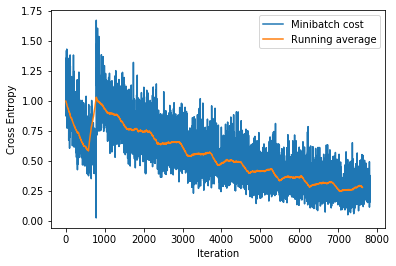

In [50]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

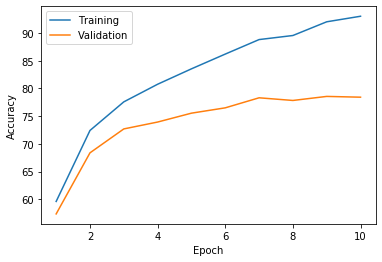

In [52]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()